# 基于线性神经网络模型实现通过蛋白质一级结构氨基酸序列对蛋白质等电点的预测

## 1.获取数据：PDB数据库

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
pd.set_option('display.max_columns', None)  #输出所有列

import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import datasets

%matplotlib inline
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus']=False

import torch
import random

### 1.1.导入数据

In [14]:
df_seq=pd.read_csv('pdb_data_seq.csv')
df_char=pd.read_csv('pdb_data_no_dups.csv')
print('Datasets have been loaded...')

Datasets have been loaded...


In [15]:
#查看数据基本信息
print(df_seq.head()) 
print(df_char.head())
#df_seq数据集包含‘StructureId’,‘chainId’,‘sequence’,‘residueCount’,'macromoleculeType’共5列 
#df_char包含‘structureId’,‘classification’,‘experimentTechnique’,‘macromoleculeType’,‘residueCount’,‘resolution’,‘structureMoleculeWeight’,‘crystallizatonMethod’,‘crystallizationTempK’,‘densityMattews’,‘densityPercentSol’，‘pdbxDetails’,‘phValue’,‘publicationYear’’'共14列信息

  structureId chainId                                           sequence  \
0        100D       A                                         CCGGCGCCGG   
1        100D       B                                         CCGGCGCCGG   
2        101D       A                                       CGCGAATTCGCG   
3        101D       B                                       CGCGAATTCGCG   
4        101M       A  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...   

   residueCount macromoleculeType  
0            20    DNA/RNA Hybrid  
1            20    DNA/RNA Hybrid  
2            24               DNA  
3            24               DNA  
4           154           Protein  
  structureId         classification experimentalTechnique macromoleculeType  \
0        100D         DNA-RNA HYBRID     X-RAY DIFFRACTION    DNA/RNA Hybrid   
1        101D                    DNA     X-RAY DIFFRACTION               DNA   
2        101M       OXYGEN TRANSPORT     X-RAY DIFFRACTION           Protein   
3      

In [16]:
#查看数据缺失情况
print(df_seq.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467304 entries, 0 to 467303
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        467304 non-null  object
 1   chainId            467294 non-null  object
 2   sequence           467276 non-null  object
 3   residueCount       467304 non-null  int64 
 4   macromoleculeType  432487 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.8+ MB
None


In [17]:
print(df_char.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141401 entries, 0 to 141400
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               141401 non-null  object 
 1   classification            141399 non-null  object 
 2   experimentalTechnique     141401 non-null  object 
 3   macromoleculeType         137636 non-null  object 
 4   residueCount              141401 non-null  int64  
 5   resolution                128589 non-null  float64
 6   structureMolecularWeight  141401 non-null  float64
 7   crystallizationMethod     96242 non-null   object 
 8   crystallizationTempK      97039 non-null   float64
 9   densityMatthews           124724 non-null  float64
 10  densityPercentSol         124749 non-null  float64
 11  pdbxDetails               118534 non-null  object 
 12  phValue                   105110 non-null  float64
 13  publicationYear           117602 non-null  f

In [18]:
#提取蛋白质序列
protein_char = df_char[df_char.macromoleculeType=='Protein']
protein_seq  = df_seq[df_seq.macromoleculeType=='Protein']
print(protein_seq.head)
print(protein_char.head)  

<bound method NDFrame.head of        structureId chainId                                           sequence  \
4             101M       A  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...   
7             102L       A  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...   
8             102M       A  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...   
11            103L       A  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...   
12            103M       A  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...   
...            ...     ...                                                ...   
467299        9XIA       A  MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...   
467300        9XIM       A  SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...   
467301        9XIM       B  SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...   
467302        9XIM       C  SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...   
467303        9XIM       D  SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...  

In [21]:
#通过structureId进行合并
protein_char=protein_char[['structureId','phValue']]
protein_seq =protein_seq[['structureId','sequence']]
print(protein_char.head(2))
print(protein_seq.head(2))

  structureId  phValue
2        101M      9.0
4        102L      NaN
  structureId                                           sequence
4        101M  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7        102L  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...


#通过structureId进行合并
protein_char=protein_char[['structureId','phValue']]
protein_seq =protein_seq[['structureId','sequence']]
print(protein_char.head(2))
print(protein_seq.head(2))

In [22]:
print(protein_seq.info())
print(protein_char.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345180 entries, 4 to 467303
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   structureId  345180 non-null  object
 1   sequence     345177 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 127798 entries, 2 to 141400
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   structureId  127798 non-null  object 
 1   phValue      95902 non-null   float64
dtypes: float64(1), object(1)
memory usage: 2.9+ MB
None


In [23]:
model_df=protein_seq.set_index('structureId').join(protein_char.set_index('structureId'))
print(model_df.head())

                                                      sequence  phValue
structureId                                                            
101M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
102L         MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...      NaN
102M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
103L         MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...      NaN
103M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0


In [24]:
print(model_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 346325 entries, 101M to 9XIM
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sequence  346322 non-null  object 
 1   phValue   259130 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.9+ MB
None


In [25]:
#查看数据缺失情况并处理数据缺失，丢弃有缺失数据
print(model_df.isnull().sum())

sequence        3
phValue     87195
dtype: int64


In [26]:
model_df=model_df.dropna()
print(model_df.shape[0])# 剩余数据量
print(model_df.info())
print(model_df.head(7))

259127
<class 'pandas.core.frame.DataFrame'>
Index: 259127 entries, 101M to 9PAI
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sequence  259127 non-null  object 
 1   phValue   259127 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB
None
                                                      sequence  phValue
structureId                                                            
101M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
102M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
103M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
104M         VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...      7.0
105M         VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...      9.0
106M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
107M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0


In [27]:
#查看phValue分布
counts=model_df['phValue'].value_counts() 
print(counts)

7.50     37141
6.50     30745
7.00     27545
8.50     20405
8.00     18654
         ...  
4.48         1
5.84         1
5.07         1
10.37        1
9.86         1
Name: phValue, Length: 355, dtype: int64


In [28]:
df = pd.DataFrame(model_df) #DateFrame结构的表格数据
print(df)

                                                      sequence  phValue
structureId                                                            
101M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
102M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
103M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
104M         VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...      7.0
105M         VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...      9.0
...                                                        ...      ...
9MSI         ANQASVVANQLIPINTALNLVMMRSEVVTPVGIPAEDIPRLVSMQV...      5.5
9NSE         SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...      6.5
9NSE         SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...      6.5
9PAI         VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...      8.5
9PAI                         MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP      8.5

[259127 rows x 2 columns]


In [31]:
df.to_csv('seq_phValue.csv')

In [32]:
print(df.head(17))
print(df.head(0))
#print(df.head(1))

                                                      sequence  phValue
structureId                                                            
101M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
102M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
103M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
104M         VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...      7.0
105M         VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...      9.0
106M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
107M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
108M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      7.0
109M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...      9.0
10GS         PPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKAS...      5.8
10GS         PPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKAS...      5.8
110M         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...  

In [34]:
A=[]
C=[]
D=[]
E=[]
F=[]
G=[]
H=[]
I=[]
K=[]
L=[]
M=[]
N=[]
O=[]
P=[]
Q=[]
R=[]
S=[]
T=[]
U=[]
V=[]
W=[]
Y=[]

In [35]:
df=pd.read_csv('seq_phValue.csv')
for seq in df.sequence:
    A.append(seq.count('A'))
    C.append(seq.count('C'))
    D.append(seq.count('D'))
    E.append(seq.count('E'))
    F.append(seq.count('F'))
    G.append(seq.count('G'))
    H.append(seq.count('H'))
    I.append(seq.count('I'))
    K.append(seq.count('K'))
    L.append(seq.count('L'))
    M.append(seq.count('M'))
    N.append(seq.count('N'))
    O.append(seq.count('O'))
    P.append(seq.count('P'))
    Q.append(seq.count('Q'))
    R.append(seq.count('R'))
    S.append(seq.count('S'))
    T.append(seq.count('T'))
    U.append(seq.count('U'))
    V.append(seq.count('V'))
    W.append(seq.count('W'))
    Y.append(seq.count('Y'))
df

,structureId,sequence,phValue
0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0
1,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0
2,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0
3,104M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,7.0
4,105M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,9.0
...,...,...,...
259122,9MSI,ANQASVVANQLIPINTALNLVMMRSEVVTPVGIPAEDIPRLVSMQV...,5.5
259123,9NSE,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,6.5
259124,9NSE,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,6.5
259125,9PAI,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...,8.5


## 保存数据

In [36]:
df.insert(loc=df.shape[1],column='A',value=A)
df.insert(loc=df.shape[1],column='C',value=C)
df.insert(loc=df.shape[1],column='D',value=D)
df.insert(loc=df.shape[1],column='E',value=E)
df.insert(loc=df.shape[1],column='F',value=F)
df.insert(loc=df.shape[1],column='G',value=G)
df.insert(loc=df.shape[1],column='H',value=H)
df.insert(loc=df.shape[1],column='I',value=I)
df.insert(loc=df.shape[1],column='K',value=K)
df.insert(loc=df.shape[1],column='L',value=L)
df.insert(loc=df.shape[1],column='M',value=M)
df.insert(loc=df.shape[1],column='N',value=N)
df.insert(loc=df.shape[1],column='O',value=O)
df.insert(loc=df.shape[1],column='P',value=P)
df.insert(loc=df.shape[1],column='Q',value=Q)
df.insert(loc=df.shape[1],column='R',value=R)
df.insert(loc=df.shape[1],column='S',value=S)
df.insert(loc=df.shape[1],column='T',value=T)
df.insert(loc=df.shape[1],column='U',value=U)
df.insert(loc=df.shape[1],column='V',value=V)
df.insert(loc=df.shape[1],column='W',value=W)
df.insert(loc=df.shape[1],column='Y',value=Y)
df.to_csv('seq_phvalue_aa.csv')
df

,structureId,sequence,phValue,A,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,T,U,V,W,Y
0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,17,0,6,14,5,11,12,9,19,18,3,2,0,4,5,4,6,5,0,9,2,3
1,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
2,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
3,104M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,7.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
4,105M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,9.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259122,9MSI,ANQASVVANQLIPINTALNLVMMRSEVVTPVGIPAEDIPRLVSMQV...,5.5,8,0,2,2,0,3,0,4,1,6,5,5,0,6,3,3,3,4,0,10,0,1
259123,9NSE,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,6.5,40,10,20,26,16,27,13,18,12,42,6,16,0,41,23,30,30,23,0,26,12,13
259124,9NSE,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,6.5,40,10,20,26,16,27,13,18,12,42,6,16,0,41,23,30,30,23,0,26,12,13
259125,9PAI,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...,8.5,24,0,19,15,21,18,12,13,19,35,12,12,0,18,20,16,26,24,0,29,4,9


## 读取数据

In [37]:
data = pd.read_csv('seq_phvalue_aa.csv')
data

,Unnamed: 0,structureId,sequence,phValue,A,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,T,U,V,W,Y
0,0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,17,0,6,14,5,11,12,9,19,18,3,2,0,4,5,4,6,5,0,9,2,3
1,1,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
2,2,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
3,3,104M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,7.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
4,4,105M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,9.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259122,259122,9MSI,ANQASVVANQLIPINTALNLVMMRSEVVTPVGIPAEDIPRLVSMQV...,5.5,8,0,2,2,0,3,0,4,1,6,5,5,0,6,3,3,3,4,0,10,0,1
259123,259123,9NSE,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,6.5,40,10,20,26,16,27,13,18,12,42,6,16,0,41,23,30,30,23,0,26,12,13
259124,259124,9NSE,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,6.5,40,10,20,26,16,27,13,18,12,42,6,16,0,41,23,30,30,23,0,26,12,13
259125,259125,9PAI,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...,8.5,24,0,19,15,21,18,12,13,19,35,12,12,0,18,20,16,26,24,0,29,4,9


## 截取部分数据，防止溢出

In [38]:
data = data[:10000]
data

,Unnamed: 0,structureId,sequence,phValue,A,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,T,U,V,W,Y
0,0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,17,0,6,14,5,11,12,9,19,18,3,2,0,4,5,4,6,5,0,9,2,3
1,1,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
2,2,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
3,3,104M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,7.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
4,4,105M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,9.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,1G2K,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,5.5,3,2,4,4,2,13,1,13,6,12,2,3,0,6,6,4,1,8,0,6,2,1
9996,9996,1G2K,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,5.5,3,2,4,4,2,13,1,13,6,12,2,3,0,6,6,4,1,8,0,6,2,1
9997,9997,1G2N,AAVQELSIERLLEMESLVADPSEEFQFLRVGPDSNVPPKFRAPVSS...,7.5,21,4,13,21,13,12,5,14,9,38,10,9,0,13,11,21,20,8,0,16,3,3
9998,9998,1G2O,MADPRPDPDELARRAAQVIADRTGIGEHDVAVVLGSGWLPAVAALG...,8.0,47,0,13,14,3,28,10,10,0,33,5,3,0,19,8,18,11,14,0,26,1,5


## 保存

In [39]:
data.to_csv('data_M.csv')

In [40]:
data = pd.read_csv('data_M.csv')
data

,Unnamed: 0,Unnamed: 0.1,structureId,sequence,phValue,A,C,D,E,F,G,H,I,K,L,M,N,O,P,Q,R,S,T,U,V,W,Y
0,0,0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,17,0,6,14,5,11,12,9,19,18,3,2,0,4,5,4,6,5,0,9,2,3
1,1,1,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
2,2,2,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,9.0,18,0,6,14,6,11,11,9,19,18,3,2,0,4,5,4,6,5,0,8,2,3
3,3,3,104M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,7.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
4,4,4,105M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,9.0,17,0,7,14,6,11,12,9,19,18,2,1,0,4,5,4,6,5,0,8,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,1G2K,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,5.5,3,2,4,4,2,13,1,13,6,12,2,3,0,6,6,4,1,8,0,6,2,1
9996,9996,9996,1G2K,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,5.5,3,2,4,4,2,13,1,13,6,12,2,3,0,6,6,4,1,8,0,6,2,1
9997,9997,9997,1G2N,AAVQELSIERLLEMESLVADPSEEFQFLRVGPDSNVPPKFRAPVSS...,7.5,21,4,13,21,13,12,5,14,9,38,10,9,0,13,11,21,20,8,0,16,3,3
9998,9998,9998,1G2O,MADPRPDPDELARRAAQVIADRTGIGEHDVAVVLGSGWLPAVAALG...,8.0,47,0,13,14,3,28,10,10,0,33,5,3,0,19,8,18,11,14,0,26,1,5


In [41]:
x = data.loc[:,'A':'Y']
y = data.loc[:,'phValue']
x,y

(       A  C   D   E   F   G   H   I   K   L   M  N  O   P   Q   R   S   T  U  \
 0     17  0   6  14   5  11  12   9  19  18   3  2  0   4   5   4   6   5  0   
 1     18  0   6  14   6  11  11   9  19  18   3  2  0   4   5   4   6   5  0   
 2     18  0   6  14   6  11  11   9  19  18   3  2  0   4   5   4   6   5  0   
 3     17  0   7  14   6  11  12   9  19  18   2  1  0   4   5   4   6   5  0   
 4     17  0   7  14   6  11  12   9  19  18   2  1  0   4   5   4   6   5  0   
 ...   .. ..  ..  ..  ..  ..  ..  ..  ..  ..  .. .. ..  ..  ..  ..  ..  .. ..   
 9995   3  2   4   4   2  13   1  13   6  12   2  3  0   6   6   4   1   8  0   
 9996   3  2   4   4   2  13   1  13   6  12   2  3  0   6   6   4   1   8  0   
 9997  21  4  13  21  13  12   5  14   9  38  10  9  0  13  11  21  20   8  0   
 9998  47  0  13  14   3  28  10  10   0  33   5  3  0  19   8  18  11  14  0   
 9999  47  0  13  14   3  28  10  10   0  33   5  3  0  19   8  18  11  14  0   
 
        V  W  Y  
 0      

In [42]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=1)  
# test_size=0.5就是把原始数据的一半作为测试集
print(x_train.shape) 
print(x_test.shape)


(8000, 22)
(2000, 22)


In [43]:
lr = LinearRegression()
lr.fit(x_train, y_train)  # 把训练集的自变量，因变量添加到函数fit()中，进行训练
print(lr.coef_)  # lr.coef_得到的是每个自变量的权重系数
print(lr.intercept_)  # lr.intercept_得到的是截距 

[ 9.47509914e-03 -1.98117355e-02 -4.97439916e-03 -5.09947890e-04
  1.05705126e-02 -1.50317897e-03  4.07404676e-02  4.52619039e-03
 -5.25167592e-04 -7.66841765e-04 -2.45274654e-04  5.38965524e-03
  7.21644966e-16 -1.07806818e-02 -3.01735658e-03  8.35373706e-03
 -2.01624444e-04 -1.36239768e-03  9.24128503e-02 -1.22865184e-02
 -4.49925973e-03 -9.81139604e-03]
6.719480027960045


## 模型评估

In [44]:
y_pred = lr.predict(x_test)
from sklearn import metrics
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('MSE:',MSE)
print('RMSE:',RMSE)


MSE: 1.5538022467786867
RMSE: 1.246516043530402


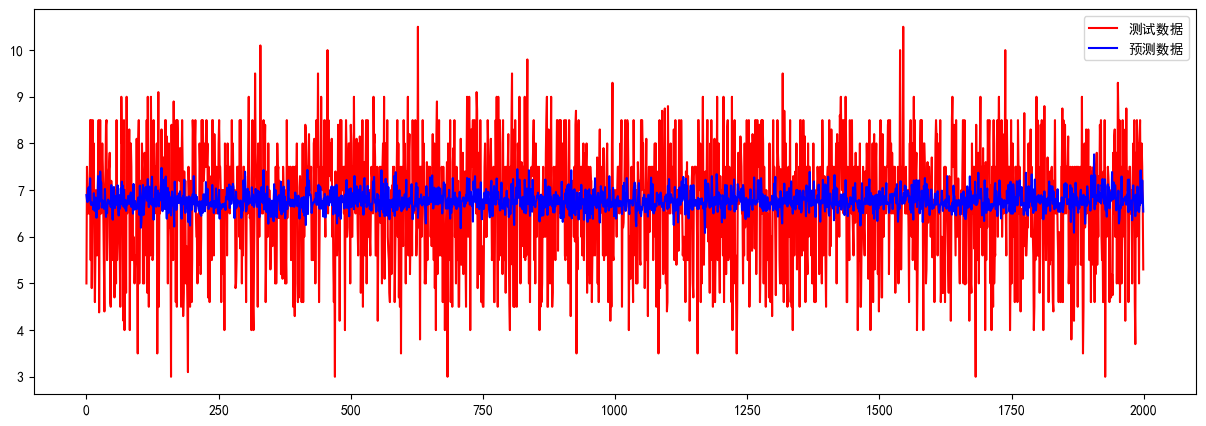

In [45]:
# 可视化查看拟合度
plt.figure(figsize=(15,5))
plt.plot(range(len(y_test)), y_test, 'r', label='测试数据')
plt.plot(range(len(y_test)), y_pred, 'b', label='预测数据')
plt.legend()

Text(0, 0.5, '预测值')

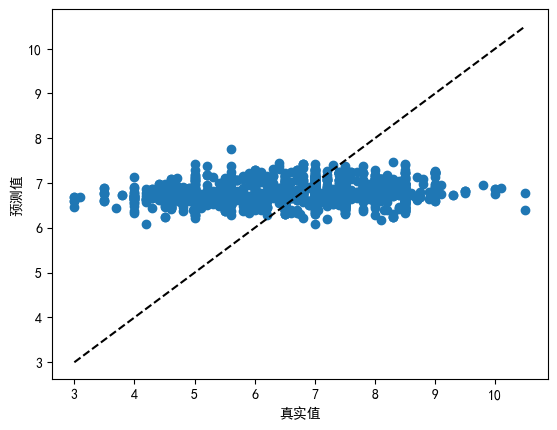

In [46]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(),y_test.max()], [y_test.min(),y_test.max()], 'k--')
plt.xlabel('真实值')
plt.ylabel('预测值')

In [48]:
type(x),type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [50]:
features=np.array(x)
features=torch.tensor(features)
labels=np.array(y)
labels=torch.tensor(labels)
type(features),type(labels)


(torch.Tensor, torch.Tensor)

In [62]:
features=features.to(torch.float32)
labels=labels.to(torch.float32)
type(features),type(labels)

(torch.Tensor, torch.Tensor)

In [53]:
#打乱数据集中的样本并以小批量方式获取数据
def data_iter(batch_size,features,labels):
    num_example = len(features)
    indices = list(range(num_example))
    #随机读取样本
    random.shuffle(indices)
    for i in range(0,num_example,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_example)]
        )
        yield features[batch_indices],labels[batch_indices]


In [54]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[11,  3, 15, 16, 13, 11,  4, 10, 19, 25,  8,  8,  0, 13,  6, 14, 10,  6,
          0,  8,  4, 13],
        [ 1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
          0,  0,  0,  0],
        [14,  3, 13,  8, 11, 11,  2, 11, 11, 18,  7,  8,  0,  9,  7, 12, 14,  7,
          0, 13,  2,  6],
        [ 7,  4,  6,  6,  5, 12,  3,  2,  1,  3,  0,  8,  0,  4,  3,  2, 15,  6,
          0,  8,  2,  7],
        [ 0,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,
          0,  2,  0,  0],
        [10,  4, 13,  8,  4, 26,  7, 10,  2, 16,  1,  8,  0,  6,  6, 11,  7,  5,
          0,  8,  1,  1],
        [ 3,  0,  1,  8,  1,  0,  1,  1,  8,  9,  3,  5,  0,  0,  4,  9,  3,  3,
          0,  3,  0,  1],
        [41,  0, 56, 46, 26, 41, 17, 37, 62, 50, 22, 43,  0, 18, 34, 25, 69, 49,
          0, 42, 12, 41],
        [38,  0, 14, 15,  9, 29,  5, 22, 21, 31,  6, 16,  0, 26, 24, 11, 18, 23,
          0, 22, 13, 15],
        [12,  7, 16, 15,  9, 22,  5, 

In [56]:
#初始化模型参数
w = torch.normal(0,0.01,size=(22,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)
w,b

#然后更新模型参数就好了

(tensor([[-5.3860e-03],
         [-4.7180e-05],
         [ 6.7927e-03],
         [-4.4255e-03],
         [-2.3391e-02],
         [-8.8650e-03],
         [-5.3869e-03],
         [ 6.8018e-03],
         [ 1.2760e-02],
         [ 2.8111e-03],
         [-9.9234e-03],
         [-2.8260e-03],
         [ 1.0563e-02],
         [ 5.9439e-03],
         [ 1.2511e-02],
         [ 8.5360e-03],
         [-6.3683e-03],
         [ 8.8587e-03],
         [-3.3219e-03],
         [ 1.5342e-02],
         [ 2.6698e-03],
         [ 4.8335e-03]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [57]:
#引入自动微分来计算梯度
#定义模型
def linreg(X,w,b): #@save
    '''线性回归模型'''
    print(w,b)
    return torch.matmul(X,w)+b

In [58]:
#定义损失函数
def squared_loss(y_hat,y):#@save
    '''均方损失'''
    return (y_hat-y.reshape(y_hat.shape))**2/2   #相同shape下运算

In [59]:
#定义优化算法:小批量随机梯度下降
def sgd(params,lr,batch_size):#@save
    '''小批量随机梯度下降'''
    with torch.no_grad(): #with自动释放资源 no_grad()使得所有tensor的requires_grad=True反向传播时不自动求导，节约显存/内存
        for param in params:
            param -=lr*param.grad/batch_size
            param.grad.zero_() #清除计算出来的grad，重新赋值为0

In [60]:
# 设置超参数
lr = 0.0001
num_epochs=3
net=linreg
loss=squared_loss


In [63]:

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        l.sum().backward()#计算[w,b]的梯度，反向传播
        sgd([w,b],lr,batch_size)#更新梯度
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

tensor([[-5.3860e-03],
        [-4.7180e-05],
        [ 6.7927e-03],
        [-4.4255e-03],
        [-2.3391e-02],
        [-8.8650e-03],
        [-5.3869e-03],
        [ 6.8018e-03],
        [ 1.2760e-02],
        [ 2.8111e-03],
        [-9.9234e-03],
        [-2.8260e-03],
        [ 1.0563e-02],
        [ 5.9439e-03],
        [ 1.2511e-02],
        [ 8.5360e-03],
        [-6.3683e-03],
        [ 8.8587e-03],
        [-3.3219e-03],
        [ 1.5342e-02],
        [ 2.6698e-03],
        [ 4.8335e-03]], requires_grad=True) tensor([0.], requires_grad=True)
tensor([[ 3.8072e-03],
        [ 1.5947e-03],
        [ 1.2789e-02],
        [ 2.5445e-03],
        [-1.8594e-02],
        [-7.6807e-05],
        [-2.5674e-03],
        [ 1.2209e-02],
        [ 1.8287e-02],
        [ 1.1885e-02],
        [-7.0433e-03],
        [ 1.1889e-03],
        [ 1.0563e-02],
        [ 1.0873e-02],
        [ 1.6258e-02],
        [ 1.4234e-02],
        [ 1.5279e-03],
        [ 1.5962e-02],
        [-3.3219e-03],
   